In [2]:
#FIgure 3, the behavioral and network analysis. will need to include the network bits

import torch
import sys
import os
import io
from os.path import exists
import numpy as np
import pickle
from scipy.special import softmax
import json
from scipy import stats
import gzip, pickle, pickletools
import warnings
import glob

from scipy.signal import butter,filtfilt


from sklearn.linear_model import LinearRegression
from scipy.stats import ranksums, wilcoxon
import statsmodels.api as sm


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import ranksums, wilcoxon

from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot


from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils.utils import CPU_Unpickler,parse_configs, displ, memcheck, opsbase, mwa
from dynamics.analysis import state_analysis as sta
from dynamics.analysis import optim

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import interpolate
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

In [3]:
#path info


kuse = [10,60,40]  # the maximum index for the final stage 5 and stage 6 training stage, by s_idx



dbase = '/scratch/dh148/dynamics/results/rnn/ac/20231003/'
# for figure 3
subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/','pkind_mem/', 'pkind_count/', 'pkind_int/', 'pkind_pred/']
# for supp. fig 3
#subdirlist = ['full_cl/', 'pkind_mem/', 'pkind_pred/', 'pkind_count/','pkind_int/']
configdir = lambda s_idx: '/home/dh148/projects/dynamics/jobs/20231003_clstudy/rnn/'+subdirlist[s_idx]
suff = '.json' #file ending
    
    
datadir_dat = lambda s_idx: dbase+subdirlist[s_idx]
fgen = lambda num,idx, base, sess, s_idx : datadir_dat(s_idx)+str(num)+'/'+base + str(num)+'_'+sess+'_'+str(idx)

fname_funs = [lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_simple',
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_int_0_'+str(idx),
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_pred_' + str(num)+'_'+str(idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'nocatch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'catch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx)+'_freeze'
             ]

configname_fun = lambda num, s_idx: configdir(s_idx) +str(num)+'.cfg'
fname_behdat_fun = lambda num,s_idx: datadir_dat(s_idx) + 'rnn_'+str(num)+'_allbeh.json'
fname_behdat_fun_1k = lambda num,s_idx: datadir_dat(s_idx) + 'rnn_'+str(num)+'_allbeh_1k.json'


In [4]:
def retrieve_behdat(fname_behdat, fname):
    """ helper code to lookup the dat in the behavioral data.
    if fname_behda is a list, just search it (for faster lookup)
    if a filename, load the file."""
    
    fname_base = fname.split('/')[-1]
    dat = None
    
    if type(fname_behdat) is list:  #easier to recylce
        datlist = fname_behdat
    else:
        #datlist = pickle.load(open(fname_behdat,'rb'))
        datlist = json.load(open(fname_behdat,'r'))
 
    for j in datlist:
        if j['name'] == fname_base:
            dat = j
            break
            
    return dat

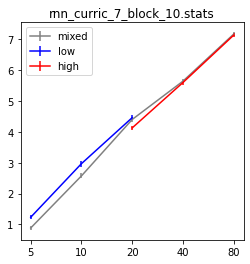

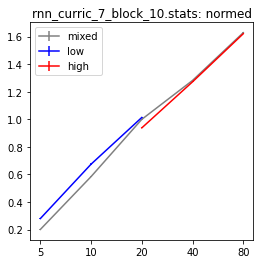

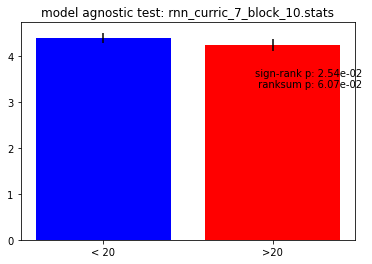

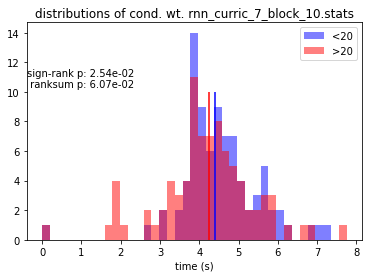

[{'win': 0.5716, 'optout': 0.4291, 'vio': 0.0}, -2.6332528701667126]
0.9255583404330032


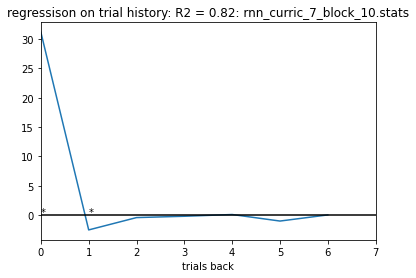

In [5]:
# a check of individual results. old code, but good to have
num = 7
idx = 10
s_idx = 3# cltype
t_idx = 5

savedir = dbase + subdirlist[s_idx] + 'figs/'

#fname_stats = fname_fun_dat(num,idx)+'.stats'
#modelname = fname_fun_dat(num,idx)+'.model'

fname_stats = fname_funs[t_idx](num,idx, s_idx)+'.stats'
modelname = fname_funs[t_idx](num,idx, s_idx)+'.model'
configname = configname_fun(num,s_idx)

dat_stat = pickle.load(open(fname_stats,'rb'))
pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(fname_stats)

if fname_stats.find('block') > -1:

    fig, fig2 = wt_vis.plotblocks(dat_stat[0], name=fname_stats.split('/')[-1])
    f,g,hh = wt_vis.plot_modelAgnosticTest(wtdat, reg_histdat, reg_blockdat, txt=fname_stats.split('/')[-1])
    print([nums,b])
    print(adapt_20_ratio)
elif fname_stats.find('_catch_') > -1:
    fig = wt_vis.plotsensitivity(dat_stat[0], idx=1, name=fname_stats.split('/')[-1])


#fig.savefig(savedir+str(num)+'_wt.pdf')
#fig.savefig(savedir+str(num)+'_'+str(idx)+'_wt.pdf')

In [5]:
# 3A, inset reward per gradient step (i.e., rewardrate), at end of training, normalized by max reward (TODO)


#hidden unit noise
#labs = ['CL','no kind (+stages)', 'no CL' ]


rr_means = []
rr_sems = []
rr_sampsforstats = []

#select averaging function
uf = np.nanmean
#uf = np.nanmedian

dt = 0.05

#kuse = [10,60,40]
kuse = [10,60,40,10,10,10,10]

#for k in [0,1,2]:
for k in [0,3,4,5,6]:
    print(k)
    
    ddir = dbase + subdirlist[k]
    rr = []
    if k > 1:
        fname_fun_dat_k = fname_funs[5]  #freeze index
    else:
        fname_fun_dat_k = fname_funs[5]  #not freeze index
    
    if k < 2:
        maxidx = 51
    elif k == 2:
        maxidx = 20
    else:
        maxidx = 10
    for j in range(1,maxidx):
        print(j,end='\r')
        
        #TODO
        if k == 2:
            fname_behdat = fname_behdat_fun_1k(j,k)
        else:
            fname_behdat = fname_behdat_fun(j,k)
           #print(fname_behdat)
        
        #print(fname_behdat)
        if exists(fname_behdat):
            
            if k == 2:
                fname_dat = fname_fun_dat_k(j,kuse[k], k).split('/')[-1]+'_1k'+suff
            else:
                fname_dat = fname_fun_dat_k(j,kuse[k], k).split('/')[-1]+suff
            print(fname_fun_dat_k(j,kuse[k], k))
            
            try:

                dat_stat = retrieve_behdat(fname_behdat,fname_dat)
                if dat_stat is not None:
                    #average reward over a gradient step of 500 timesteps divided by time, divided by optimal amount
                    #so reward rate (rew/s), divided by max reward per trial

                    rr.append(uf(dat_stat['rewardrate_pergradstep'])/dt)
                    #rr.append(uf(dat_stat['rewardrate_pergradstep'])/dt/V_b)
                    #rr.append(uf(dat_stat['rewards_pertrial'])/V_b)
            except:
                print('json error:' +str(j))
                print(fname_dat)
        else:
            print('skipping beh file:'+fname_behdat)

            
            
    print(len(rr))
    rr_means.append(np.nanmean(rr))
    rr_sampsforstats.append(rr)
    rr_sems.append(np.std(rr)/np.sqrt(len(rr)))
    
    

0
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/1/rnn_curric_1_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/2/rnn_curric_2_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/3/rnn_curric_3_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/4/rnn_curric_4_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/5/rnn_curric_5_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/6/rnn_curric_6_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/7/rnn_curric_7_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/8/rnn_curric_8_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/9/rnn_curric_9_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/10/rnn_curric_10_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/11/rnn_curric_11_block_10
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/12/rnn_curric_12_block_10
/scratch/dh148/dynamics/results/

In [9]:
with open('/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_int/rnn_2_allbeh.json','r') as f:
    test = json.load(f)

In [6]:
rr_means

[5.66344362554878, 4.480707878664394, 3.2599630355376816]

In [6]:
print('rank sum of reward rates for best models')
print(ranksums(rr_sampsforstats[0],rr_sampsforstats[1]))
print(ranksums(rr_sampsforstats[1],rr_sampsforstats[2]))

rank sum of reward rates for best models
RanksumsResult(statistic=4.89153306465932, pvalue=1.0005358106908438e-06)
RanksumsResult(statistic=2.1551433495577172, pvalue=0.03115061837043333)


In [8]:
print('rank sum of reward rates for best models: partial kindergarten')
print('full vs mem')
print(ranksums(rr_sampsforstats[0],rr_sampsforstats[1]))
print('full vs count')
print(ranksums(rr_sampsforstats[0],rr_sampsforstats[2]))
print('full vs int')
print(ranksums(rr_sampsforstats[0],rr_sampsforstats[3]))
print('full vs pred')
print(ranksums(rr_sampsforstats[0],rr_sampsforstats[4]))

rank sum of reward rates for best models: partial kindergarten
full vs mem
RanksumsResult(statistic=-1.277798247604809, pvalue=0.20132057245559598)
full vs count
RanksumsResult(statistic=3.9837239484149927, pvalue=6.78436770516957e-05)
full vs int
RanksumsResult(statistic=2.178146085472069, pvalue=0.02939516248273049)
full vs pred
RanksumsResult(statistic=4.198479956415801, pvalue=2.6871263243089095e-05)


In [38]:
#calculate reward per gradient step from slimdat. end of training comparison across CL types

# NOTE: long runtime. about an hour

#hidden unit noise
#subdirlist = ['full_cl/','nok_cl/','nok_nocl/']
#labs = ['kind CL','classic CL', 'no CL', ]
#slist = [0,1,2]

#sub-kidergarten
subdirlist = ['full_cl/','nok_cl/','nok_nocl/','pkind_mem/','pkind_count/', 'pkind_int/', 'pkind_pred/']
slist = [0,3,4,5,6]
labs = ['CL','classic','noCL','mem', 'count', 'int', 'pred']

rr_means_all = []
rr_sems_all = []
dt = 0.05

#Vusevec = [0,0,0,V_nc,V_c,V_b]

#for k in [1]:
for s_idx in slist:
    #print(k)
    
    ddir = dbase + subdirlist[s_idx]
    
    #for each CL type
    rr_means_k = []
    rr_sems_k = []
    
    for tphase in [3,4,5]:
        print([s_idx,tphase],end='\r')
        #Vuse = Vusevec[n]
        fname_fun_dat_k = fname_funs[tphase]  #freeze index
        if tphase < 5:
            nmax = 11
        else:
            if s_idx == 1:
                nmax = 61
            elif s_idx == 2:
                nmax = 41
            else:
                nmax = 11
        for idx in range(1,nmax):
     
            rr_idx = []  # for each index

            for num in range(1,51):
                # TODO
                if s_idx == 2:
                    fname_behdat = fname_behdat_fun_1k(num,s_idx)
                else:
                    fname_behdat = fname_behdat_fun(num,s_idx)
                    
                if exists(fname_behdat):
                    if s_idx == 2:
                        fname_dat = fname_fun_dat_k(num,idx, s_idx).split('/')[-1]+'_1k'+suff
                    else:
                        fname_dat = fname_fun_dat_k(num,idx, s_idx).split('/')[-1]+suff
                    
                    try:
                        dat_stat = retrieve_behdat(fname_behdat,fname_dat)
                        if dat_stat is not None:

                            rr_idx.append(uf(dat_stat['rewardrate_pergradstep'])/dt)
                            #rr_idx.append(uf(dat_stat['rewardrate_pergradstep'])/dt/Vuse)
                            #rr_idx.append(uf(dat_stat['rewards_pertrial'])/Vuse)
                    except:
                        print('Json error: ' + str([s_idx,tphase,num,idx]))

            
            rr_means_k.append(uf(rr_idx))
            rr_sems_k.append(np.nanstd(rr_idx)/np.sqrt(len(rr_idx)))
            
            #print(rr_means_k)
        

    rr_means_all.append(rr_means_k)
    rr_sems_all.append(rr_sems_k)
    

In [36]:
len(rr_means_all)

5

In [9]:
#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
#with open(savedir+'fig3_rrate.dat','wb') as f:
#    pickle.dump([rr_means_all, rr_sems_all],f)

In [39]:
savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
with open(savedir+'fig3_rrate_pkind.dat','wb') as f:
    pickle.dump([rr_means_all, rr_sems_all],f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/


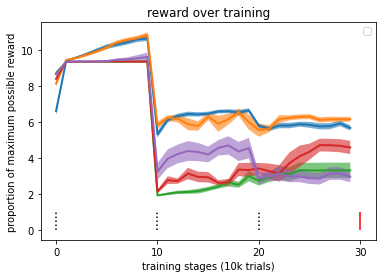

In [42]:

n = len(rr_means_all[0])

plt.fill_between(range(n),np.array(rr_means_all[0])+np.array(rr_sems_all[0]) , 
                 np.array(rr_means_all[0])-np.array(rr_sems_all[0]), alpha = 0.6)
plt.plot(range(n),rr_means_all[0], linewidth=2)

plt.fill_between(range(n),np.array(rr_means_all[1])+np.array(rr_sems_all[1]) , 
                 np.array(rr_means_all[1])-np.array(rr_sems_all[1]), alpha = 0.6)
plt.plot(range(n),rr_means_all[1], linewidth=2)

plt.fill_between(range(n),np.array(rr_means_all[2])+np.array(rr_sems_all[2]) , 
                 np.array(rr_means_all[2])-np.array(rr_sems_all[2]), alpha = 0.6)
plt.plot(range(n),rr_means_all[2], linewidth=2)


plt.fill_between(range(n),np.array(rr_means_all[3])+np.array(rr_sems_all[3]) , 
                 np.array(rr_means_all[3])-np.array(rr_sems_all[3]), alpha = 0.6)
plt.plot(range(n),rr_means_all[3], linewidth=2)

plt.fill_between(range(n),np.array(rr_means_all[4])+np.array(rr_sems_all[4]) , 
                 np.array(rr_means_all[4])-np.array(rr_sems_all[4]), alpha = 0.6)
plt.plot(range(n),rr_means_all[4], linewidth=2)

#plt.xticks([0,10,20,30,40,50,60,70,80],
#           labels = {'no catch', 'catch','block','10k','20k','30k','40k','50k','60k'})
plt.xticks([0,10,20,30,40,50,60,70,80])
#[plt.vlines(k,0,10, linestyle='dotted', color = 'k') for k in [0,10,20] ]
#plt.vlines(30,0,10, color = 'r',linestyle = 'solid')
[plt.vlines(k,0,1.0, linestyle='dotted', color = 'k') for k in [0,10,20] ]
plt.vlines(30,0,1.0, color = 'r',linestyle = 'solid')
plt.xlabel('training stages (10k trials)')
plt.ylabel('proportion of maximum possible reward')
plt.title('reward over training')

plt.legend()

#plt.savefig(savedir+'reward_overtraining_allcl_smooth.pdf')


#plt.savefig(savedir+'reward_overtraining_allcl.pdf')

plt.savefig(savedir+'reward_overtraining_allcl_pkind.pdf')

print(savedir)
plt.show()

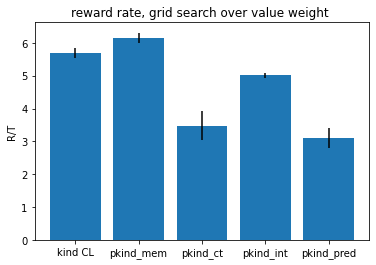

In [9]:
#A,  inset:  reward rate per CL type
labs = ['kind CL','classic CL', 'no CL' ]
labs = ['kind CL','pkind_mem', 'pkind_ct', 'pkind_int', 'pkind_pred']
ntype = len(labs)+1
fig = plt.figure()
plt.bar(range(1,ntype),rr_means)
plt.errorbar(range(1,ntype), rr_means, rr_sems, color = 'k', linestyle = 'none')
plt.xticks(range(1,ntype), labels = labs)
plt.ylabel('R/T')
plt.title('reward rate, grid search over value weight ')
#fig.savefig(savedir+'clres_rr_bar.pdf')
#fig.savefig(savedir+'cl_pkind_rr_bar.pdf')
plt.show()
#plt.ylim(0.25,0.35)


In [6]:
def beh_acrosstraining(s_idx = 0, num = 0, switchblock = False):
    """
    retrieves behavioral data for a single network across training 
    s_idx: CL type 0:full, 1:nok_cl, 2: nok_nocl, others are pkind?
    num: RNN number
    """
    
    stagelist = []
    idxlist = []
    
    #lists for block-relevant things
    stagelist_block = []
    idxlist_block = []
    
    #lin sensitivity, wt ratio, historical regression, opt out, violation
    sensitivity = []
    sensitivity_pval = []
    optout = []
    vio = []
    wt_ratio = []
    histreg_coeff = []
    histreg_pval = []
    rs_hist = []  #variance explained
    

    # load the bulk behavioral data
    fname_fun_stage = lambda stage, idx: fname_funs[stage](num, idx, s_idx)  # helper name fun for given RNN
    freezemax_idx = 0 # track the last freeze block sesion for each RNN. only plot this. 
    if s_idx == 2:
        fname_behdat = fname_behdat_fun_1k(num,s_idx)
    else:
        fname_behdat = fname_behdat_fun(num,s_idx)
    print(fname_behdat)
    
    if exists(fname_behdat):
        with open(fname_behdat,'r') as f:
            alldat_list = json.load(f)
    else:
        print('behdat does not exist. aborting: '+ fname_behdat)
        return None
    
    # find the last frozen session. ideally 10 for kindergarten, 40/60 for classic, 20 for no CL
    #TODO: eventually delete this
    
    
    #stage = 6
    #blockmax_idx = 0
    #for idx in range(1,61):  
    #    if s_idx == 2:
    #        fname = fname_fun_stage(stage, idx)+'_1k'+suff   
    #    else:
    #        fname = fname_fun_stage(stage, idx)+suff        
    #    if exists(fname):
    #        blockmax_idx = idx
    
    
    # ideally will all be same idx when trainign is complete
    idx_max = [0,0,0,10,10,kuse[s_idx]]  # max possible idx per training stage
    print(idx_max)
    for stage in [3,4,5]:
        #if stage < 6:
        #    idxrange = range(1,idx_max[stage]+1)
        #else: 
        #    idxrange = [blockmax_idx]
            
        idxrange = range(1,idx_max[stage]+1)  # number samples per training stage
        for idx in idxrange:
            print([stage,idx], end='\r')
            if s_idx == 2:
                fname = fname_fun_stage(stage, idx).split('/')[-1]+'_1k'+suff # no original training data for nocl
            else:
                fname = fname_fun_stage(stage, idx).split('/')[-1]+suff 
                
            #load data    
            try:
                dat_stat = retrieve_behdat(fname_behdat,fname)
            except:
                print('Json error. skipping')
                dat_stat = None
            
            if dat_stat is None:
                print('json error or ot added to beh yet:' + fname)
                stagelist.append(stage)
                idxlist.append(idx)
                sensitivity.append(np.nan)
                sensitivity_pval.append(np.nan)
                vio.append(np.nan)
                optout.append(np.nan)
                stagelist_block.append(stage)
                idxlist_block.append(idx)
                histreg_coeff.append(np.nan*np.ones((9,))) #blockdat or regular? 
                histreg_pval.append(np.nan*np.ones((9,)))  #TODO
                rs_hist.append(np.nan)
                wt_ratio.append(np.nan) 
                continue

            # run analysis. normalize w.t. to 20ul for regressions first, avoid MAT if not in block stage
            ops = utils.opsbase()  #shouldnt need specific ops, just dt and stuff
            
            # set necessary ops
            ops['displevel'] = 3
            pc_old = ops['pcatch']
            if stage == 5:
                ops['useblocks'] = True
                ops['pcatch'] = pc_old
            elif stage == 3:
                ops['pcatch'] = 0
                ops['useblocks'] = False
            else:
                ops['useblocks'] = False
                ops['pcatch'] = pc_old
            # analyze       
            try:       
                wt_dict, linreg, numdict, rho_all, ops = wta.parsesimulation(dat_stat, ops, allreg=True)       
            except ValueError:
                print('issue with parsesimulation(): '+fname)
                
            if stage == 5:
                try:
                    #normalize wait times in regression to 20uL
                    #dat_stat['wt'] = dat_stat['wt']/(wt_dict['wt_mixed'][2]/ops['dt'])
                    #or z-score
                    dat_stat['wt'] = (dat_stat['wt']-np.nanmean(dat_stat['wt']))/np.nanstd(dat_stat['wt'])
                    
                    wtlist, reg_hist, reg_block = wta.modelagnostic_test(dat_stat, dt=ops['dt'])
                except ValueError:
                    print('encountered an immature network that cant do MAT with inferred block wait times')
                    #create fake block and regression structs that play nice with later math
                    histreg_coeff = list(np.nan*np.ones((9,))) #blockdat or regular? 
                    histreg_pval = list(np.nan*np.ones((9,)))  #TODO
                    rs_hist = np.nan         
                    reg_block = [histreg_coeff, rs_hist, histreg_pval]
                    wtlist = None
                    reg_hist = None  
            else:
                wtlist = None
                reg_hist = None
                reg_block = None

            #grab mixed slopes from block stage, all trial slope from catch, nocatch
            if fname.find('block') == -1:
                slope = linreg['m']
                pval = linreg['p']
            else:
                slope = linreg['m_mixed']
                pval = linreg['p_mixed']

            nums = numdict
            reg_blockdat = reg_block

            #append to save lists
            stagelist.append(stage)
            idxlist.append(idx)
            sensitivity.append(slope)
            sensitivity_pval.append(pval)
            vio.append(numdict['vio'])
            optout.append(numdict['optout'])
            stagelist_block.append(stage)
            idxlist_block.append(idx)

            # check block coefficient and wt ratio
            if stage > 4:                
                histreg_coeff.append(reg_block[0]) #blockdat or regular? 
                histreg_pval.append(reg_block[2])  #TODO
                rs_hist.append(reg_block[1])

                adapt_20_ratio = wt_dict['wt_high'][2] / wt_dict['wt_low'][2]  
                wt_ratio.append(adapt_20_ratio) 
            else:
                histreg_coeff.append(np.nan*np.ones((9,))) #blockdat or regular? 
                histreg_pval.append(np.nan*np.ones((9,)))  #TODO
                rs_hist.append(np.nan)
                wt_ratio.append(np.nan) 
              

    d = {'sensitivity':sensitivity,
    'sensitivity_pval': sensitivity_pval,
    'optout':optout,
    'vio': vio,
    'wt_ratio':wt_ratio,
    'histreg_coeff':histreg_coeff,
    'histreg_pval':histreg_pval,
    'rs_hist': rs_hist}

                
    return d, stagelist, idxlist, stagelist_block, idxlist_block
                

In [10]:
with open('/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_3_allbeh.json','r') as f:
    testdat = json.load(f)
    
    
test = [k['name'] for k in testdat]
print(test)

['rnn_curric_3_nocatch_1.json', 'rnn_curric_3_nocatch_2.json', 'rnn_curric_3_nocatch_3.json', 'rnn_curric_3_nocatch_4.json', 'rnn_curric_3_nocatch_5.json', 'rnn_curric_3_nocatch_6.json', 'rnn_curric_3_nocatch_7.json', 'rnn_curric_3_nocatch_8.json', 'rnn_curric_3_nocatch_9.json', 'rnn_curric_3_nocatch_10.json', 'rnn_curric_3_catch_1.json', 'rnn_curric_3_catch_2.json', 'rnn_curric_3_catch_3.json', 'rnn_curric_3_catch_4.json', 'rnn_curric_3_catch_5.json', 'rnn_curric_3_catch_6.json', 'rnn_curric_3_catch_7.json', 'rnn_curric_3_catch_8.json', 'rnn_curric_3_catch_9.json', 'rnn_curric_3_catch_10.json', 'rnn_curric_3_block_1.json', 'rnn_curric_3_block_2.json', 'rnn_curric_3_block_3.json', 'rnn_curric_3_block_4.json', 'rnn_curric_3_block_5.json', 'rnn_curric_3_block_6.json', 'rnn_curric_3_block_7.json', 'rnn_curric_3_block_8.json', 'rnn_curric_3_block_9.json', 'rnn_curric_3_block_10.json']


In [7]:

def acrosstraining_dat_allnet(s_idx = 0, switchblock = False):

    #get across-training behavioral data, averaged across all networks
    
    lenlist = []
    slopelist = []
    optoutlist = []
    adaptationlist = []
    stagelist_list= []
    block_coeff_list = []
    block_coeffcross_list = []
    
    losslist_L = []
    losslist_pi =[]
    losslist_V = []
    losslist_ent = []
    losslist_inf = []
    losslist_kind = []
    lenlist_losses = []
    
    
    print(s_idx)
    
    n_rnn = 0
    
    if s_idx < 2:
        idxmax = 51
    elif s_idx == 2:
        idxmax = 21
    else:
        idxmax = 11

    for j in range(1,idxmax):

        nnum = j
        print(nnum)
        
        #check if behavioral file exists. if not skip that RNN and notify
        if s_idx ==2:
            fname_behdat = datadir_dat(s_idx)+'rnn_'+str(nnum)+'_allbeh_1k.json'
        else:
            fname_behdat = datadir_dat(s_idx)+'rnn_'+str(nnum)+'_allbeh.json'
          

        if exists(fname_behdat): 
            d, stagelist, idxlist, stagelist_block, idxlist_block = beh_acrosstraining(num = nnum, s_idx = s_idx, 
                                                                                   switchblock = switchblock)
            n_rnn +=1
        else: 
            print('no behavioral file found. skipping this RNN: '+fname_behdat)
            continue

        nsamps = len(d['wt_ratio']) #how many sessions/ data points for that RNN

        #grab items of interest, 
        slopelist.append(np.array(d['sensitivity']))
        optoutlist.append(np.array(d['optout']))
        adaptationlist.append(np.array(d['wt_ratio']))

        #handle regression coefficients. should you mask them by pval? no, pval based on gaussian stats...
        #if d['histreg_coeff'][0] == np.nan:
        #    block_coeff_list.append(np.nan)
        #else:
        #block_coeff_pval = [k[-1]< 0.05 for k in d['histreg_pval']]
        block_coeff = [k[-1] for k in d['histreg_coeff']]
        #block_coeff_sig = np.array(block_coeff_pval).astype(int)*np.array(block_coeff)
        block_coeff_sig = np.array(block_coeff)
        block_coeff_list.append(block_coeff_sig)

        #keepping track of stage
        lenlist.append(nsamps)
        stagelist_list.append(stagelist)


    #post-process data. 
    # - pad RNNs that didn't finish training
    # - set reward sensitivity to 0 if stage < 4
    # - set adaptation to 0 if stage < 5

    #pad predlist with nans
    lmax = max(lenlist)
    slopelist_padded = np.nan*np.ones((n_rnn,lmax))
    optoutlist_padded = np.nan*np.ones((n_rnn,lmax))
    ratiolist_padded = np.nan*np.ones((n_rnn,lmax))
    block_coeff_list_padded = np.nan*np.ones((n_rnn,lmax))
    for j in range(n_rnn):
        lj = lenlist[j]
        slopelist_padded[j,:lj] = np.squeeze(slopelist[j])
        optoutlist_padded[j,:lj] = np.squeeze(optoutlist[j])
        ratiolist_padded[j,:lj] = np.squeeze(adaptationlist[j])
        block_coeff_list_padded[j,:lj] = np.squeeze(block_coeff_list[j])
    

    #lenlist[5]
    #len(slopelist[5])

    return lenlist, slopelist_padded, optoutlist_padded, ratiolist_padded, stagelist_list, block_coeff_list_padded




In [8]:
lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list = acrosstraining_dat_allnet(s_idx = 0)
lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl = acrosstraining_dat_allnet(s_idx = 2)
lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl = acrosstraining_dat_allnet(s_idx = 1)


0
1
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_1_allbeh.json
[0, 0, 0, 10, 10, 10]
json error or ot added to beh yet:rnn_curric_1_block_9.json
25, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_2_allbeh.json
[0, 0, 0, 10, 10, 10]
35, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_3_allbeh.json
[0, 0, 0, 10, 10, 10]
45, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_4_allbeh.json
[0, 0, 0, 10, 10, 10]
55, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_5_allbeh.json
[0, 0, 0, 10, 10, 10]
json error or ot added to beh yet:rnn_curric_5_block_9.json
65, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_6_allbeh.json
[0, 0, 0, 10, 10, 10]
json error or ot added to beh yet:rnn_curric_6_block_6.json
75, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_7_allbeh.json
[0, 0, 0, 10, 10, 10]
85, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/rnn_8_allbeh.json
[0, 0, 0, 10, 

json error or ot added to beh yet:rnn_curric_1_catch_5_1k.json
json error or ot added to beh yet:rnn_curric_1_catch_6_1k.json
json error or ot added to beh yet:rnn_curric_1_catch_7_1k.json
json error or ot added to beh yet:rnn_curric_1_catch_8_1k.json
json error or ot added to beh yet:rnn_curric_1_catch_9_1k.json
json error or ot added to beh yet:rnn_curric_1_catch_10_1k.json
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeout

json error or ot added to beh yet:rnn_curric_5_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_5_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_6_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_7_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_8_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_9_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_10_1k.json
sign rank test will fail. look like all values are the same (likely timeouts)
65, 40]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_nocl/rnn_6_allbeh_1k.json
[0, 0, 0, 10, 10, 40]
json error or ot added to beh yet:rnn_curric_6_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_6_noca

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
95, 40]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_nocl/rnn_9_allbeh_1k.json
[0, 0, 0, 10, 10, 40]
json error or ot added to beh yet:rnn_curric_9_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_9_catch_1_1k.json
json error or ot added

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
14
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_nocl/rnn_14_allbeh_1k.json
[0, 0, 0, 10, 10, 40]
json error or ot added to beh yet:rnn_curric_14_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_3_1k.j

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
18, 40]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_nocl/rnn_18_allbeh_1k.json
[0, 0, 0, 10, 10, 40]
json error or ot added to beh yet:rnn_curric_18_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_18_noc

[0, 0, 0, 10, 10, 60]
json error or ot added to beh yet:rnn_curric_33_block_28.json
34, 60]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_34_allbeh.json
[0, 0, 0, 10, 10, 60]
json error or ot added to beh yet:rnn_curric_34_block_17.json
35, 60]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_35_allbeh.json
[0, 0, 0, 10, 10, 60]
json error or ot added to beh yet:rnn_curric_35_block_32.json
36, 60]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_36_allbeh.json
[0, 0, 0, 10, 10, 60]
json error or ot added to beh yet:rnn_curric_36_block_19.json
37, 60]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_37_allbeh.json
[0, 0, 0, 10, 10, 60]
json error or ot added to beh yet:rnn_curric_37_block_29.json
38, 60]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_38_allbeh.json
[0, 0, 0, 10, 10, 60]
39, 60]
/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/rnn_39_allbeh.json
[0, 0, 0, 10, 10, 60]
json error or ot added to beh yet:rnn_curric

In [14]:

lenlist_3, slopelist_3, optoutlist_3, ratiolist_3, stagelist_list_3, block_coeff_list_3 = acrosstraining_dat_allnet(s_idx = 3)
lenlist_4, slopelist_4, optoutlist_4, ratiolist_4, stagelist_list_4, block_coeff_list_4 = acrosstraining_dat_allnet(s_idx = 4)

lenlist_5, slopelist_5, optoutlist_5, ratiolist_5, stagelist_list_5, block_coeff_list_5 = acrosstraining_dat_allnet(s_idx = 5)
lenlist_6, slopelist_6, optoutlist_6, ratiolist_6, stagelist_list_6, block_coeff_list_6 = acrosstraining_dat_allnet(s_idx = 6)
#lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list = acrosstraining_dat_allnet(s_idx = 0)

3
1
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_1_allbeh.json
[0, 0, 0, 10, 10, 10]
25, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_2_allbeh.json
[0, 0, 0, 10, 10, 10]
35, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_3_allbeh.json
[0, 0, 0, 10, 10, 10]
json error or ot added to beh yet:rnn_curric_3_nocatch_1.json
45, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_4_allbeh.json
[0, 0, 0, 10, 10, 10]
55, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_5_allbeh.json
[0, 0, 0, 10, 10, 10]
65, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_6_allbeh.json
[0, 0, 0, 10, 10, 10]
75, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_7_allbeh.json
[0, 0, 0, 10, 10, 10]
85, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_8_allbeh.json
[0, 0, 0, 10, 10, 10]
95, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_mem/rnn_9_allbeh.json
[0, 0, 0, 

[0, 0, 0, 10, 10, 10]
85, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_pred/rnn_8_allbeh.json
[0, 0, 0, 10, 10, 10]
95, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_pred/rnn_9_allbeh.json
[0, 0, 0, 10, 10, 10]
10, 10]
/scratch/dh148/dynamics/results/rnn/ac/20231003/pkind_pred/rnn_10_allbeh.json
[0, 0, 0, 10, 10, 10]


In [15]:
# for fig 3

dopkind = True

if not dopkind:

    dosave = True
    if dosave:
        savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
        savename = savedir + 'Fig3dat_20231130.dat'
        l1 = [lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list]
        l2 = [lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl]
        #l2 = []
        #l3 = []
        l3 = [lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl]
        with open(savename,'wb') as f:
            pickle.dump([l1,l2,l3,],f)
else:
    print('pkind')
    dosave = True
    if dosave:
        savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
        savename = savedir + 'Fig3dat_20231130_pkind.dat'
        l1 = [lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list]
        l3 = [lenlist_3, slopelist_3, optoutlist_3, ratiolist_3, stagelist_list_3, block_coeff_list_3]
        l4 = [lenlist_4, slopelist_4, optoutlist_4, ratiolist_4, stagelist_list_4, block_coeff_list_4]
        l5 = [lenlist_5, slopelist_5, optoutlist_5, ratiolist_5, stagelist_list_5, block_coeff_list_5]
        l6 = [lenlist_6, slopelist_6, optoutlist_6, ratiolist_6, stagelist_list_6, block_coeff_list_6]
        with open(savename,'wb') as f:
            pickle.dump([l1,l3,l4, l5, l6],f)

pkind


In [90]:
#reload data
if not dopkind:
    with open(savename,'rb') as f:
        l1,l2,l3  =  pickle.load(f)

    [lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list]  = l1
    [lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl] = l2
    [lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl] = l3



In [ ]:
# for 

In [10]:
#remove outside >95% CI

#slopes
n_n, nx = slopelist.shape
test = np.array(slopelist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_mask = test
slopelist_mask[maskout] = np.nan

n_n, nx = slopelist_nok_cl.shape
test = np.array(slopelist_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_nok_cl_mask = test
slopelist_nok_cl_mask[maskout] = np.nan

n_n, nx = slopelist_nok_nocl.shape
test = np.array(slopelist_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_nok_nocl_mask = test
slopelist_nok_nocl_mask[maskout] = np.nan

#optout
n_n, nx = optoutlist.shape
test = np.array(optoutlist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_mask = test
optoutlist_mask[maskout] = np.nan

n_n, nx = optoutlist_nok_cl.shape
test = np.array(optoutlist_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_nok_cl_mask = test
optoutlist_nok_cl_mask[maskout] = np.nan

n_n, nx = optoutlist_nok_nocl.shape
test = np.array(optoutlist_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_nok_nocl_mask = test
optoutlist_nok_nocl_mask[maskout] = np.nan


#ratios
n_n, nx = ratiolist.shape
test = np.array(ratiolist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
ratiolist_mask = test
ratiolist_mask[maskout] = np.nan

n_n, nx = ratiolist_nok_cl.shape
test = np.array(ratiolist_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
ratiolist_nok_cl_mask = test
ratiolist_nok_cl_mask[maskout] = np.nan

n_n, nx = ratiolist_nok_nocl.shape
test = np.array(ratiolist_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
ratiolist_nok_nocl_mask = test
ratiolist_nok_nocl_mask[maskout] = np.nan

#block coeff
n_n, nx = block_coeff_list.shape
test = np.array(block_coeff_list)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
block_coeff_list_mask = test
block_coeff_list_mask[maskout] = np.nan

n_n, nx = block_coeff_list_nok_cl.shape
test = np.array(block_coeff_list_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
block_coeff_list_nok_cl_mask = test
block_coeff_list_nok_cl_mask[maskout] = np.nan

n_n, nx = block_coeff_list_nok_nocl.shape
test = np.array(block_coeff_list_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
block_coeff_list_nok_nocl_mask = test
block_coeff_list_nok_nocl_mask[maskout] = np.nan




/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/


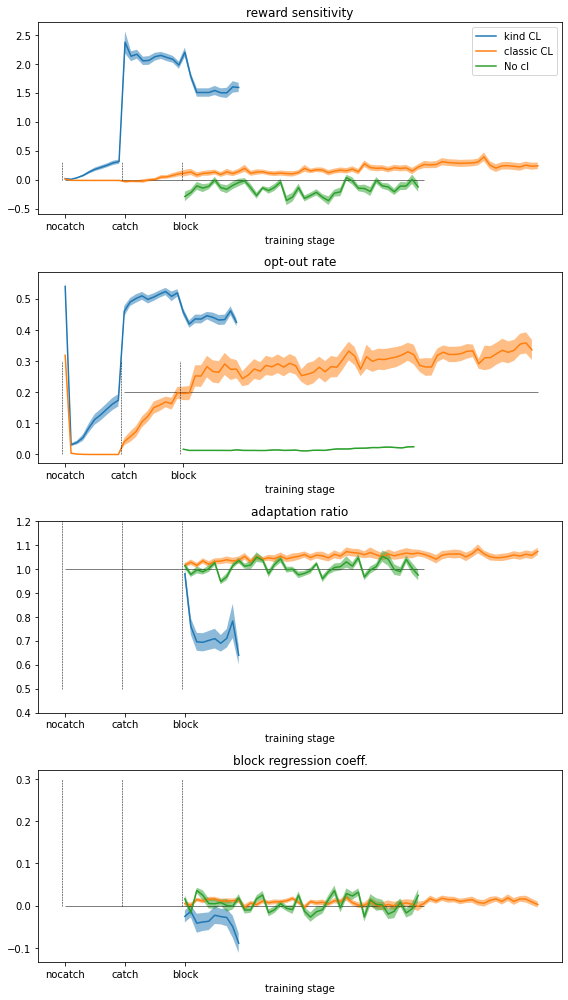

In [13]:
#C, plot everything behavioral and save


#plotting
n_rnn = 50 
n_rnn_nok_nocl = 20
lmax = max(lenlist)
lmax_nokcl = max(lenlist_nok_cl)
lmax_nocl = max(lenlist_nok_nocl)

fun = np.nanmean
#fun = np.nanmedian

slopemean = fun(slopelist_mask, axis=0)
slopesem = np.nanstd(slopelist_mask, axis=0)/np.sqrt(n_rnn)
optoutmean = fun(optoutlist_mask, axis=0)
optoutsem = np.nanstd(optoutlist_mask, axis=0)/np.sqrt(n_rnn)
ratiomean = fun(ratiolist_mask, axis=0)
ratiosem = np.nanstd(ratiolist_mask, axis=0)/np.sqrt(n_rnn)
blockcoeffmean = fun(block_coeff_list_mask, axis=0)
blockcoeffsem = np.nanstd(block_coeff_list_mask, axis=0)/np.sqrt(n_rnn)


slopemean_nok_nocl = fun(slopelist_nok_nocl_mask, axis=0)
slopesem_nok_nocl = np.nanstd(slopelist_nok_nocl_mask, axis=0)/np.sqrt(n_rnn)
optoutmean_nok_nocl = fun(optoutlist_nok_nocl_mask, axis=0)
optoutsem_nok_nocl = np.nanstd(optoutlist_nok_nocl_mask, axis=0)/np.sqrt(n_rnn)
ratiomean_nok_nocl = fun(ratiolist_nok_nocl_mask, axis=0)
ratiosem_nok_nocl = np.nanstd(ratiolist_nok_nocl_mask, axis=0)/np.sqrt(n_rnn)
blockcoeffmean_nok_nocl = fun(block_coeff_list_nok_nocl_mask, axis=0)
blockcoeffsem_nok_nocl = np.nanstd(block_coeff_list_nok_nocl_mask, axis=0)/np.sqrt(n_rnn)


slopemean_nok_cl = fun(slopelist_nok_cl_mask, axis=0)
slopesem_nok_cl = np.nanstd(slopelist_nok_cl_mask, axis=0)/np.sqrt(n_rnn_nok_nocl)
optoutmean_nok_cl = fun(optoutlist_nok_cl_mask, axis=0)
optoutsem_nok_cl = np.nanstd(optoutlist_nok_cl_mask, axis=0)/np.sqrt(n_rnn_nok_nocl)
ratiomean_nok_cl = fun(ratiolist_nok_cl_mask, axis=0)
ratiosem_nok_cl = np.nanstd(ratiolist_nok_cl_mask, axis=0)/np.sqrt(n_rnn_nok_nocl)
blockcoeffmean_nok_cl = fun(block_coeff_list_nok_cl_mask, axis=0)
blockcoeffsem_nok_cl = np.nanstd(block_coeff_list_nok_cl_mask, axis=0)/np.sqrt(n_rnn_nok_nocl)



fig,ax = plt.subplots(4,1,figsize = (8,14))

ax[0].hlines(0.0, 0,lmax_nocl, color = 'k', linewidth = 0.5)
ax[0].plot(range(lmax),slopemean, label = 'kind CL')
ax[0].fill_between(range(lmax),slopemean-slopesem, slopemean+slopesem, alpha = 0.5)
ax[0].plot(range(lmax_nokcl),slopemean_nok_cl, label = 'classic CL')
ax[0].fill_between(range(lmax_nokcl),slopemean_nok_cl-slopesem_nok_cl, slopemean_nok_cl+slopesem_nok_cl, alpha = 0.5)
ax[0].plot(range(lmax_nocl),slopemean_nok_nocl, label = 'No cl')
ax[0].fill_between(range(lmax_nocl),slopemean_nok_nocl-slopesem_nok_nocl, slopemean_nok_nocl+slopesem_nok_nocl, alpha = 0.5)
ax[0].legend()

ax[1].hlines(0.2, 10,20+lmax_nocl, color = 'k', linewidth = 0.5)
ax[1].plot(range(lmax),optoutmean)
ax[1].fill_between(range(lmax),optoutmean-optoutsem, optoutmean+optoutsem, alpha = 0.5)
ax[1].plot(range(lmax_nokcl),optoutmean_nok_cl)
ax[1].fill_between(range(lmax_nokcl),optoutmean_nok_cl-optoutsem_nok_cl, optoutmean_nok_cl+optoutsem_nok_cl, alpha = 0.5)
ax[1].plot(range(lmax_nocl),optoutmean_nok_nocl)
ax[1].fill_between(range(lmax_nocl),optoutmean_nok_nocl-optoutsem_nok_nocl, optoutmean_nok_nocl+optoutsem_nok_nocl, alpha = 0.5)

ax[2].hlines(1.0, 0,lmax_nocl, color = 'k', linewidth = 0.5)
ax[2].plot(range(lmax),ratiomean)
ax[2].fill_between(range(lmax),ratiomean-ratiosem, ratiomean+ratiosem, alpha = 0.5)
ax[2].plot(range(lmax_nokcl),ratiomean_nok_cl)
ax[2].fill_between(range(lmax_nokcl),ratiomean_nok_cl-ratiosem_nok_cl, ratiomean_nok_cl+ratiosem_nok_cl, alpha = 0.5)
ax[2].plot(range(lmax_nocl),ratiomean_nok_nocl)
ax[2].fill_between(range(lmax_nocl),ratiomean_nok_nocl-ratiosem_nok_nocl, ratiomean_nok_nocl+ratiosem_nok_nocl, alpha = 0.5)
ax[2].set_ylim([0.4,1.2])

ax[3].hlines(0.0, 0,+lmax_nocl, color = 'k', linewidth = 0.5)
ax[3].plot(range(lmax),blockcoeffmean)
ax[3].fill_between(range(lmax),blockcoeffmean-blockcoeffsem, blockcoeffmean+blockcoeffsem, alpha = 0.5)
ax[3].plot(range(lmax_nokcl),blockcoeffmean_nok_cl)
ax[3].fill_between(range(lmax_nokcl),blockcoeffmean_nok_cl-blockcoeffsem_nok_cl, blockcoeffmean_nok_cl+blockcoeffsem_nok_cl, alpha = 0.5)
ax[3].plot(range(lmax_nocl),blockcoeffmean_nok_nocl)
ax[3].fill_between(range(lmax_nocl),blockcoeffmean_nok_nocl-blockcoeffsem_nok_nocl, blockcoeffmean_nok_nocl+blockcoeffsem_nok_nocl, alpha = 0.5)



#find a completed network and grab its stagelist
stagelist = stagelist_list[np.argmax(lenlist_nok_cl)]
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block', 6:'freeze'}
typeloc = [np.argwhere(stagelist == k)[0,0] for k in np.unique(stagelist) ]


for j in range(4):
    [ax[j].vlines(k-0.5,  0, 0.3, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    ax[j].set_xticks(typeloc, labels = [stagedict[stagelist[k]] for k in typeloc], rotation = 0)
    ax[j].set_xlabel('training stage')
    #ax[j].set_ylabel('wt slope')
    
[ax[2].vlines(k-0.5,  0.5, 1.2, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]

#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
ax[0].set_title('reward sensitivity')
ax[1].set_title('opt-out rate')
ax[2].set_title('adaptation ratio')
ax[3].set_title('block regression coeff.')

#plt.xlim([2,28])
#plt.ylim([0,10])
plt.tight_layout()


print(savedir)
plt.savefig(savedir+'beh_acrosstraining_clstudy_.pdf')
plt.show()
    
    

    

In [146]:
savedir

'/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/figs/'

In [16]:
#supp 3

#remove outside >95% CI

#slopes
n_n, nx = slopelist.shape
test = np.array(slopelist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_mask = test
slopelist_mask[maskout] = np.nan

n_n, nx = slopelist_3.shape
test = np.array(slopelist_3)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_3_mask = test
slopelist_3_mask[maskout] = np.nan

n_n, nx = slopelist_4.shape
test = np.array(slopelist_4)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_4_mask = test
slopelist_4_mask[maskout] = np.nan

n_n, nx = slopelist_5.shape
test = np.array(slopelist_5)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_5_mask = test
slopelist_5_mask[maskout] = np.nan

n_n, nx = slopelist_6.shape
test = np.array(slopelist_6)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
slopelist_6_mask = test
slopelist_6_mask[maskout] = np.nan



#optout
n_n, nx = optoutlist.shape
test = np.array(optoutlist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_mask = test
optoutlist_mask[maskout] = np.nan

n_n, nx = optoutlist_3.shape
test = np.array(optoutlist_3)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_3_mask = test
optoutlist_3_mask[maskout] = np.nan

n_n, nx = optoutlist_4.shape
test = np.array(optoutlist_4)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_4_mask = test
optoutlist_4_mask[maskout] = np.nan

n_n, nx = optoutlist_5.shape
test = np.array(optoutlist_5)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_5_mask = test
optoutlist_5_mask[maskout] = np.nan

n_n, nx = optoutlist_6.shape
test = np.array(optoutlist_6)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
optoutlist_6_mask = test
optoutlist_6_mask[maskout] = np.nan



#ratios
n_n, nx = ratiolist.shape
test = np.array(ratiolist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
ratiolist_mask = test
ratiolist_mask[maskout] = np.nan

n_n, nx = ratiolist_3.shape
test = np.array(ratiolist_3)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
ratiolist_3_mask = test
ratiolist_3_mask[maskout] = np.nan

n_n, nx = ratiolist_4.shape
test = np.array(ratiolist_4)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
ratiolist_4_mask = test
ratiolist_4_mask[maskout] = np.nan

n_n, nx = ratiolist_5.shape
test = np.array(ratiolist_5)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
ratiolist_5_mask = test
ratiolist_5_mask[maskout] = np.nan

n_n, nx = ratiolist_6.shape
test = np.array(ratiolist_6)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
ratiolist_6_mask = test
ratiolist_6_mask[maskout] = np.nan



#block coeff
n_n, nx = block_coeff_list.shape
test = np.array(block_coeff_list)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
block_coeff_list_mask = test
block_coeff_list_mask[maskout] = np.nan

n_n, nx = block_coeff_list_3.shape
test = np.array(block_coeff_list_3)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
block_coeff_list_3_mask = test
block_coeff_list_3_mask[maskout] = np.nan

n_n, nx = block_coeff_list_4.shape
test = np.array(block_coeff_list_4)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
block_coeff_list_4_mask = test
block_coeff_list_4_mask[maskout] = np.nan

n_n, nx = block_coeff_list_5.shape
test = np.array(block_coeff_list_5)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
block_coeff_list_5_mask = test
block_coeff_list_5_mask[maskout] = np.nan

n_n, nx = block_coeff_list_6.shape
test = np.array(block_coeff_list_6)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > 90)
masktest = np.array(test2 > 90)
block_coeff_list_6_mask = test
block_coeff_list_6_mask[maskout] = np.nan



/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/


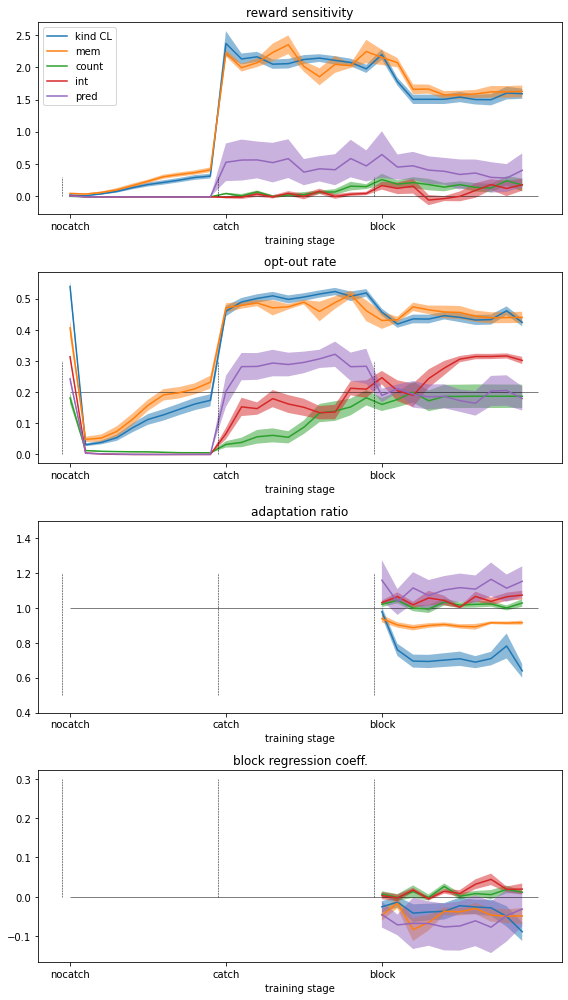

In [17]:
# supp fig


#plotting
n_rnn = 50 
n_rnnpkind = 10
lmax = max(lenlist)
lmax_3 = max(lenlist_3)
lmax_4 = max(lenlist_4)
lmax_5 = max(lenlist_5)
lmax_6 = max(lenlist_6)

fun = np.nanmean
#fun = np.nanmedian

slopemean = fun(slopelist_mask, axis=0)
slopesem = np.nanstd(slopelist_mask, axis=0)/np.sqrt(n_rnn)
optoutmean = fun(optoutlist_mask, axis=0)
optoutsem = np.nanstd(optoutlist_mask, axis=0)/np.sqrt(n_rnn)
ratiomean = fun(ratiolist_mask, axis=0)
ratiosem = np.nanstd(ratiolist_mask, axis=0)/np.sqrt(n_rnn)
blockcoeffmean = fun(block_coeff_list_mask, axis=0)
blockcoeffsem = np.nanstd(block_coeff_list_mask, axis=0)/np.sqrt(n_rnn)


slopemean_3 = fun(slopelist_3_mask, axis=0)
slopesem_3 = np.nanstd(slopelist_3_mask, axis=0)/np.sqrt(n_rnnpkind)
optoutmean_3 = fun(optoutlist_3_mask, axis=0)
optoutsem_3 = np.nanstd(optoutlist_3_mask, axis=0)/np.sqrt(n_rnnpkind)
ratiomean_3 = fun(ratiolist_3_mask, axis=0)
ratiosem_3 = np.nanstd(ratiolist_3_mask, axis=0)/np.sqrt(n_rnnpkind)
blockcoeffmean_3 = fun(block_coeff_list_3_mask, axis=0)
blockcoeffsem_3 = np.nanstd(block_coeff_list_3_mask, axis=0)/np.sqrt(n_rnnpkind)

slopemean_4 = fun(slopelist_4_mask, axis=0)
slopesem_4 = np.nanstd(slopelist_4_mask, axis=0)/np.sqrt(n_rnnpkind)
optoutmean_4 = fun(optoutlist_4_mask, axis=0)
optoutsem_4 = np.nanstd(optoutlist_4_mask, axis=0)/np.sqrt(n_rnnpkind)
ratiomean_4 = fun(ratiolist_4_mask, axis=0)
ratiosem_4 = np.nanstd(ratiolist_4_mask, axis=0)/np.sqrt(n_rnnpkind)
blockcoeffmean_4 = fun(block_coeff_list_4_mask, axis=0)
blockcoeffsem_4 = np.nanstd(block_coeff_list_4_mask, axis=0)/np.sqrt(n_rnnpkind)

slopemean_5 = fun(slopelist_5_mask, axis=0)
slopesem_5 = np.nanstd(slopelist_5_mask, axis=0)/np.sqrt(n_rnnpkind)
optoutmean_5 = fun(optoutlist_5_mask, axis=0)
optoutsem_5 = np.nanstd(optoutlist_5_mask, axis=0)/np.sqrt(n_rnnpkind)
ratiomean_5 = fun(ratiolist_5_mask, axis=0)
ratiosem_5 = np.nanstd(ratiolist_5_mask, axis=0)/np.sqrt(n_rnnpkind)
blockcoeffmean_5 = fun(block_coeff_list_5_mask, axis=0)
blockcoeffsem_5 = np.nanstd(block_coeff_list_5_mask, axis=0)/np.sqrt(n_rnnpkind)

slopemean_6 = fun(slopelist_6_mask, axis=0)
slopesem_6 = np.nanstd(slopelist_6_mask, axis=0)/np.sqrt(n_rnnpkind)
optoutmean_6 = fun(optoutlist_6_mask, axis=0)
optoutsem_6 = np.nanstd(optoutlist_6_mask, axis=0)/np.sqrt(n_rnnpkind)
ratiomean_6 = fun(ratiolist_6_mask, axis=0)
ratiosem_6 = np.nanstd(ratiolist_6_mask, axis=0)/np.sqrt(n_rnnpkind)
blockcoeffmean_6 = fun(block_coeff_list_6_mask, axis=0)
blockcoeffsem_6 = np.nanstd(block_coeff_list_6_mask, axis=0)/np.sqrt(n_rnnpkind)




fig,ax = plt.subplots(4,1,figsize = (8,14))

ax[0].hlines(0.0, 0,lmax, color = 'k', linewidth = 0.5)
ax[0].plot(range(lmax),slopemean, label = 'kind CL')
ax[0].fill_between(range(lmax),slopemean-slopesem, slopemean+slopesem, alpha = 0.5)
ax[0].plot(range(lmax_3),slopemean_3, label = 'mem')
ax[0].fill_between(range(lmax_3),slopemean_3-slopesem_3, slopemean_3+slopesem_3, alpha = 0.5)
ax[0].plot(range(lmax_4),slopemean_4, label = 'count')
ax[0].fill_between(range(lmax_4),slopemean_4-slopesem_4, slopemean_4+slopesem_4, alpha = 0.5)
ax[0].plot(range(lmax_5),slopemean_5, label = 'int')
ax[0].fill_between(range(lmax_5),slopemean_5-slopesem_5, slopemean_5+slopesem_5, alpha = 0.5)
ax[0].plot(range(lmax_6),slopemean_6, label = 'pred')
ax[0].fill_between(range(lmax_6),slopemean_6-slopesem_6, slopemean_6+slopesem_6, alpha = 0.5)

ax[0].legend()

ax[1].hlines(0.2, 0,lmax, color = 'k', linewidth = 0.5)
ax[1].plot(range(lmax),optoutmean)
ax[1].fill_between(range(lmax),optoutmean-optoutsem, optoutmean+optoutsem, alpha = 0.5)
ax[1].plot(range(lmax_3),optoutmean_3)
ax[1].fill_between(range(lmax_3),optoutmean_3-optoutsem_3, optoutmean_3+optoutsem_3, alpha = 0.5)
ax[1].plot(range(lmax_4),optoutmean_4)
ax[1].fill_between(range(lmax_4),optoutmean_4-optoutsem_4, optoutmean_4+optoutsem_4, alpha = 0.5)
ax[1].plot(range(lmax_5),optoutmean_5)
ax[1].fill_between(range(lmax_5),optoutmean_5-optoutsem_5, optoutmean_5+optoutsem_5, alpha = 0.5)
ax[1].plot(range(lmax_6),optoutmean_6)
ax[1].fill_between(range(lmax_6),optoutmean_6-optoutsem_6, optoutmean_6+optoutsem_6, alpha = 0.5)

ax[2].hlines(1.0, 0,lmax, color = 'k', linewidth = 0.5)
ax[2].plot(range(lmax),ratiomean)
ax[2].fill_between(range(lmax),ratiomean-ratiosem, ratiomean+ratiosem, alpha = 0.5)
ax[2].plot(range(lmax_3),ratiomean_3)
ax[2].fill_between(range(lmax_3),ratiomean_3-ratiosem_3, ratiomean_3+ratiosem_3, alpha = 0.5)
ax[2].plot(range(lmax_4),ratiomean_4)
ax[2].fill_between(range(lmax_4),ratiomean_4-ratiosem_4, ratiomean_4+ratiosem_4, alpha = 0.5)
ax[2].plot(range(lmax_5),ratiomean_5)
ax[2].fill_between(range(lmax_5),ratiomean_5-ratiosem_5, ratiomean_5+ratiosem_5, alpha = 0.5)
ax[2].plot(range(lmax_6),ratiomean_6)
ax[2].fill_between(range(lmax_6),ratiomean_6-ratiosem_6, ratiomean_6+ratiosem_6, alpha = 0.5)
ax[2].set_ylim([0.4,1.5])


ax[3].hlines(0.0, 0,lmax, color = 'k', linewidth = 0.5)
ax[3].plot(range(lmax),blockcoeffmean)
ax[3].fill_between(range(lmax),blockcoeffmean-blockcoeffsem, blockcoeffmean+blockcoeffsem, alpha = 0.5)
ax[3].plot(range(lmax_3),blockcoeffmean_3)
ax[3].fill_between(range(lmax_3),blockcoeffmean_3-blockcoeffsem_3, blockcoeffmean_3+blockcoeffsem_3, alpha = 0.5)
ax[3].plot(range(lmax_4),blockcoeffmean_4)
ax[3].fill_between(range(lmax_4),blockcoeffmean_4-blockcoeffsem_4, blockcoeffmean_4+blockcoeffsem_4, alpha = 0.5)
ax[3].plot(range(lmax_5),blockcoeffmean_5)
ax[3].fill_between(range(lmax_5),blockcoeffmean_5-blockcoeffsem_5, blockcoeffmean_5+blockcoeffsem_5, alpha = 0.5)
ax[3].plot(range(lmax_6),blockcoeffmean_6)
ax[3].fill_between(range(lmax_6),blockcoeffmean_6-blockcoeffsem_6, blockcoeffmean_6+blockcoeffsem_6, alpha = 0.5)



#find a completed network and grab its stagelist
stagelist = stagelist_list[np.argmax(lenlist)]
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block', 6:'freeze'}
typeloc = [np.argwhere(stagelist == k)[0,0] for k in np.unique(stagelist) ]


for j in range(4):
    [ax[j].vlines(k-0.5,  0, 0.3, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    ax[j].set_xticks(typeloc, labels = [stagedict[stagelist[k]] for k in typeloc], rotation = 0)
    ax[j].set_xlabel('training stage')
    #ax[j].set_ylabel('wt slope')
    
[ax[2].vlines(k-0.5,  0.5, 1.2, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]

#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
ax[0].set_title('reward sensitivity')
ax[1].set_title('opt-out rate')
ax[2].set_title('adaptation ratio')
ax[3].set_title('block regression coeff.')

#plt.xlim([2,28])
#plt.ylim([0,10])
plt.tight_layout()


print(savedir)
plt.savefig(savedir+'beh_acrosstraining_clstudy_pkind.pdf')
plt.show()
    
    

    

In [30]:
blockcoeffmean

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  0.05906142,  0.04146993,
       -0.04345555, -0.02814986, -0.0389644 , -0.04156694, -0.03739433,
       -0.03731819, -0.03552042, -0.05398017, -0.04161343, -0.05010637])

In [37]:
# supp fig. loss over training

# supp. fig losses across training. make into function that grabs them all, un-normalized by weight

def loss_acrosstraining(s_idx = 0, num = 0):
    """
    gets the loss functions across an entire set of training. does not include kindergarten 
    s_idx: CL type 0:full, 1:nok_cl, 2: nok_nocl, others are pkind?
    num: RNN number
    """
    
    
    stagelist = []
    idxlist = []

    loss = []
    loss_actor = []
    loss_critic = []
    loss_ent = []
    loss_kind = []
    loss_pred = []
    
    #sem or std? 
    sem_loss = []
    sem_actor = []
    sem_critic = []
    sem_ent = []
    sem_kind = []
    sem_pred = []

    fname_fun_stage = lambda stage, idx: fname_funs[stage](num, idx, s_idx)
    
    #load one of the .dat files form that directory to brab the ops struct
    #print('loading .dat file to get ops')
    #dat = CPU_Unpickler(open(fname_fun_stage(6,10)+'.dat', 'rb')).load()
    #ops = dat['ops']
    #lambda_kind = ops['lambda_supervised']  #kindergarten weight
    #lambda_pred = ops['lambda_pred'] #block inference
    if s_idx == 0:
        lambda_kind = 10
        lambda_pred = 0.5
    else:
        lambda_kind = np.nan
        lambda_pred = np.nan
    lambda_ent = 1.0  #al0eady included in cost
    lambda_critic = 1.0  #alread included in cost
    
    
    for stage in [3,4,5]:
        for idx in range(1,41):
            fname_slim = fname_fun_stage(stage, idx)+ '.slimdat'
            
            if exists(fname_slim):
                sdat = pickle.load(open(fname_slim, 'rb'))
                stagelist.append(stage)
                idxlist.append(idx)
  
                #s_critic = 1/ops['lambda_value']
                #s_ent = 1/ops['lambda_ent']
                #s_pred = 1/ops['lambda_pred']
                
                #TODO
                loss.append(np.nanmean(np.array(sdat['loss'])))
                loss_actor.append(np.nanmean(np.array([k[0] for k in sdat['loss_aux']])))
                loss_critic.append(np.nanmean(np.array([k[1] for k in sdat['loss_aux']])))
                loss_ent.append(np.nanmean(np.array([k[2] for k in sdat['loss_aux']])))
                loss_kind.append(lambda_kind*np.nanmean(np.array([k[3] for k in sdat['loss_aux']])))
                loss_pred.append(lambda_pred*np.nanmean(np.array([k[4] for k in sdat['loss_aux']])))
                
                
                sem_loss.append(np.std(np.array(sdat['loss']))/len(sdat['loss']))

                
    losses= {'L':loss, 'actor': loss_actor, 'critic':loss_critic, 'ent':loss_ent, 'kind': loss_kind, 'pred': loss_pred,
            'sem_L': sem_loss, 'sem_actor': sem_actor, 'sem_critic':sem_critic, 'sem_ent':sem_ent,
             'sem_kind':sem_kind, 'sem_pred': sem_pred}
                
    return losses, stagelist, idxlist


# the loss averaged across all networks

def acrosstraining_loss_allnet(s_idx = 0, switchblock = False):

    losslist_L = []
    losslist_pi =[]
    losslist_V = []
    losslist_ent = []
    losslist_inf = []
    losslist_kind = []
    lenlist = []
    stagelist_list = []
    
    
    print(s_idx)
    
    n_rnn = 0

    for j in range(1,61):

        #extract beh from each session
       # print(j)
        nnum = j
        print(nnum,end='\r')
        
        losses, stagelist, idx = loss_acrosstraining(num = num, s_idx = s_idx)
        nsamps = len(stagelist) 
        
        if nsamps > 0:
            n_rnn +=1
                 
        #handle losses:
        losslist_L.append(losses['L'])
        losslist_pi.append(losses['actor'])
        losslist_V.append(losses['critic'])
        losslist_ent.append(losses['ent'])
        losslist_inf.append(losses['pred'])
        losslist_kind.append(losses['kind'])
        
        #keepping track of stage
        lenlist.append(nsamps)
        stagelist_list.append(stagelist)


    #post-process data. 
    # - pad RNNs that didn't finish training
    # - set reward sensitivity to 0 if stage < 4
    # - set adaptation to 0 if stage < 5
        
    #handle losses
    lmax_loss = max(lenlist)
    losslist_L_padded = np.nan*np.ones((n_rnn,lmax_loss))
    losslist_pi_padded = np.nan*np.ones((n_rnn,lmax_loss))
    losslist_V_padded = np.nan*np.ones((n_rnn,lmax_loss))
    losslist_ent_padded = np.nan*np.ones((n_rnn,lmax_loss))
    losslist_inf_padded = np.nan*np.ones((n_rnn,lmax_loss))
    losslist_kind_padded = np.nan*np.ones((n_rnn,lmax_loss))
    for j in range(n_rnn):
        lj = lenlist[j]
        losslist_L_padded[j,:lj] = np.squeeze(losslist_L[j])
        losslist_pi_padded[j,:lj] = np.squeeze(losslist_pi[j])
        losslist_V_padded[j,:lj] = np.squeeze(losslist_V[j])
        losslist_ent_padded[j,:lj] = np.squeeze(losslist_ent[j])
        losslist_inf_padded[j,:lj] = np.squeeze(losslist_inf[j])
        losslist_kind_padded[j,:lj] = np.squeeze(losslist_kind[j])
        
        
    #lenlist[5]
    #len(slopelist[5])
    lossdict = {'L':losslist_L_padded, 'pi':losslist_pi_padded, 'V':losslist_V_padded,
                'ent':losslist_ent_padded, 'inf':losslist_inf_padded, 'kind':losslist_kind_padded}
    
    return lenlist, stagelist_list, lossdict



#the analysis call
lenlist_loss, stagelist_list_loss, lossdict = acrosstraining_loss_allnet(s_idx = 0)
lenlist_loss_nok_nocl, stagelist_list_loss_nok_nocl, lossdict_nok_nocl = acrosstraining_loss_allnet(s_idx = 2)
lenlist_loss_nok_cl, stagelist_list_loss_nok_cl, lossdict_nok_cl = acrosstraining_loss_allnet(s_idx = 1)




-0.03651401169034888

In [11]:
savedir


'/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'

In [ ]:
#plot the lsses over training


#plotting
n_rnn = 20 
lmax = lossdict['L'].shape[1]
lmax_nokcl = lossdict_nok_cl['L'].shape[1]
lmax_nocl = lossdict_nok_nocl['L'].shape[1]

fun = np.nanmean
#fun = np.nanmedian

keylist = ['pi','V','ent','kind','inf']


lossmean = [fun(lossdict[k], axis=0) for k in keylist]
losssem = [np.nanstd(lossdict[k], axis=0)/np.sqrt(n_rnn) for k in keylist]
lossmean_nok_nocl = [fun(lossdict_nok_nocl[k], axis=0) for k in keylist]
losssem_nok_nocl= [np.nanstd(lossdict_nok_nocl[k], axis=0)/np.sqrt(n_rnn) for k in keylist]
lossmean_nok_cl = [fun(lossdict_nok_cl[k], axis=0) for k in keylist]
losssem_nok_cl = [np.nanstd(lossdict_nok_cl[k], axis=0)/np.sqrt(n_rnn) for k in keylist]



fig,ax = plt.subplots(5,1,figsize = (8,14))

for j in range(len(keylist)):

    ax[j].plot(range(lmax),lossmean[j], label = 'full cl')
    ax[j].fill_between(range(lmax),lossmean[j]-losssem[j], lossmean[j]+losssem[j], alpha = 0.5)
    ax[j].plot(range(lmax_nokcl),lossmean_nok_cl[j], label = 'stages only')
    ax[j].fill_between(range(lmax_nokcl),lossmean_nok_cl[j]-losssem_nok_cl[j], losssem_nok_cl[j]+lossmean_nok_cl[j], alpha = 0.5)
    ax[j].plot(range(20,20+lmax_nocl), lossmean_nok_nocl[j], label = 'no cl')
    ax[j].fill_between(range(20,20+lmax_nocl),lossmean_nok_nocl[j]-losssem_nok_nocl[j], lossmean_nok_nocl[j]+losssem_nok_nocl[j], alpha = 0.5)
    ax[j].legend()


#find a completed network and grab its stagelist
stagelist = stagelist_list_loss[np.argmax(lenlist_loss)]
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
typeloc = [np.argwhere(stagelist == k)[0,0] for k in np.unique(stagelist) ]


for j in range(4):
    [ax[j].vlines(k-0.5,  -0.1, 0.1, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    ax[j].hlines(0,0,lmax,color='k',linewidth = 0.5, linestyle = 'dashed')
    ax[j].set_xticks(typeloc, labels = [stagedict[stagelist[k]] for k in typeloc], rotation = 0)
    ax[j].set_xlabel('training stage')
    #ax[j].set_ylabel('wt slope')
    
[ax[2].vlines(k-0.5,  0.1, 3, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
[ax[4].vlines(k-0.5,  0, 0.4, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    
#[ax[2].vlines(k-0.5,  0.5, 1.2, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]


[ax[j].set_title('loss: '+keylist[j]) for j in range(len(keylist))]


#plt.xlim([2,28])
#plt.ylim([0,10])
plt.tight_layout()


print(savedir)
#plt.savefig(savedir+'beh_acrosstraining_clstudy.pdf')
plt.show()
    
    

    